In [ ]:
!pip install opendatasets --upgrade -q

In [ ]:
import opendatasets as od
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
import warnings
warnings.filterwarnings('ignore')


In [ ]:
data_url = "https://www.kaggle.com/splcher/animefacedataset"

In [ ]:
DATA_DIR = './animefacedataset'

In [ ]:
od.download(data_url)

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:06<00:00, 59.8MB/s]


In [ ]:
os.listdir(DATA_DIR + '/images')[:5]

['34585_2011.jpg',
 '26083_2009.jpg',
 '19725_2007.jpg',
 '15143_2006.jpg',
 '49653_2015.jpg']

In [ ]:
len(os.listdir(DATA_DIR + '/images'))

63565

In [ ]:
os.listdir('./')

['.config', 'kaggle.json', 'animefacedataset', 'sample_data']

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
img0 = DATA_DIR + '/images/640_2000.jpg'

In [ ]:
train_ds = ImageFolder(
    DATA_DIR, transform = tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)

    ])
)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [ ]:
def denormalize(images, means, std):
  means = torch.tensor(means).reshape(1,3,1,1)
  std = torch.tensor(std).reshape(1,3,1,1)
  return images * std + means

In [ ]:
def show_batches(dl):
  for img, label in train_dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm_images = denormalize(img, *stats)
    ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1, 2, 0))
    break

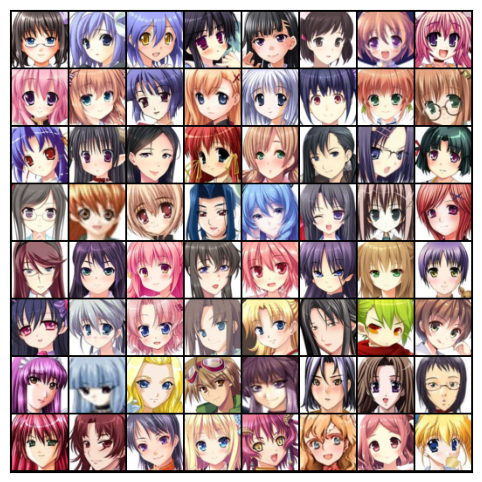

In [ ]:
show_batches(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
# means = (0.5, 0.5, 0.5)  # Your mean values
# std = (0.5, 0.5, 0.5) # Your standard deviation values

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images.detach()[:nmax],*stats), nrow=8).permute(1, 2, 0))


torch.Size([128, 3, 64, 64])


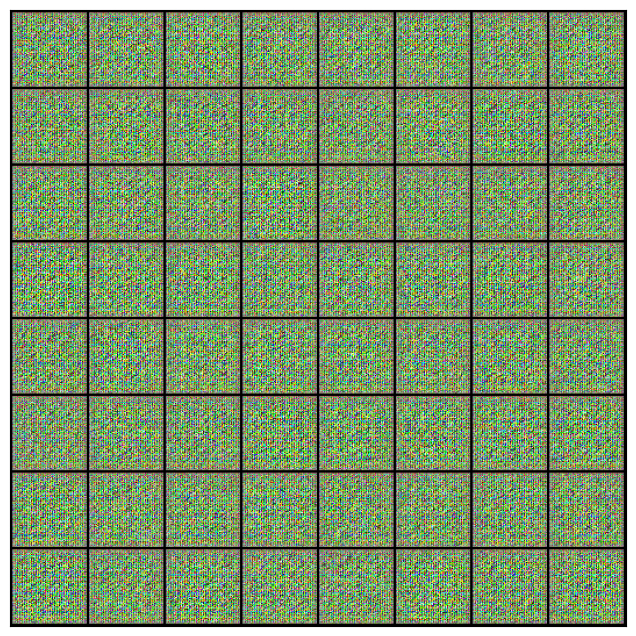

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward() # compute gradients
    opt_g.step() # update weights

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated-images'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denormalize(fake_images,*stats), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
stats = (torch.tensor(stats[0]).to(device), torch.tensor(stats[1]).to(device))

Saving generated-images-0000.png


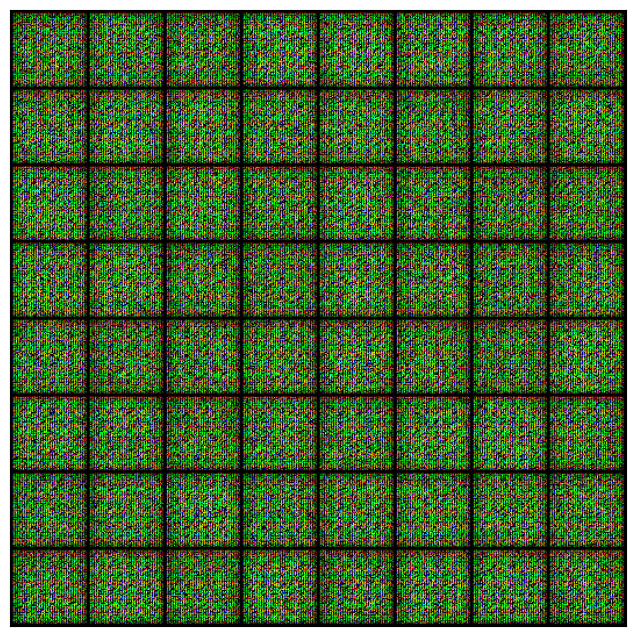

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
stats = (torch.tensor(stats[0]).to(device), torch.tensor(stats[1]).to(device))

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()


    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []


    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)


        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 15

In [ ]:
history = fit(epochs, lr)

100%|██████████| 497/497 [02:58<00:00,  2.79it/s]


Epoch [1/15], loss_g: 4.6398, loss_d: 0.5535, real_score: 0.8897, fake_score: 0.3017
Saving generated-images-0001.png


100%|██████████| 497/497 [02:58<00:00,  2.78it/s]


Epoch [2/15], loss_g: 5.5740, loss_d: 0.5309, real_score: 0.8078, fake_score: 0.2309
Saving generated-images-0002.png


100%|██████████| 497/497 [02:58<00:00,  2.79it/s]


Epoch [3/15], loss_g: 6.8123, loss_d: 0.4602, real_score: 0.9795, fake_score: 0.3317
Saving generated-images-0003.png


100%|██████████| 497/497 [02:57<00:00,  2.80it/s]


Epoch [4/15], loss_g: 5.8575, loss_d: 0.2986, real_score: 0.9158, fake_score: 0.1780
Saving generated-images-0004.png


100%|██████████| 497/497 [02:57<00:00,  2.80it/s]


Epoch [5/15], loss_g: 9.4789, loss_d: 0.6748, real_score: 0.5818, fake_score: 0.0001
Saving generated-images-0005.png


100%|██████████| 497/497 [02:57<00:00,  2.80it/s]


Epoch [6/15], loss_g: 9.1899, loss_d: 3.0172, real_score: 0.1362, fake_score: 0.0000
Saving generated-images-0006.png


100%|██████████| 497/497 [02:57<00:00,  2.80it/s]


Epoch [7/15], loss_g: 6.6329, loss_d: 0.0796, real_score: 0.9384, fake_score: 0.0088
Saving generated-images-0007.png


100%|██████████| 497/497 [02:58<00:00,  2.78it/s]


Epoch [8/15], loss_g: 7.0051, loss_d: 0.1242, real_score: 0.9006, fake_score: 0.0058
Saving generated-images-0008.png


100%|██████████| 497/497 [02:58<00:00,  2.78it/s]


Epoch [9/15], loss_g: 6.2648, loss_d: 0.1232, real_score: 0.9737, fake_score: 0.0886
Saving generated-images-0009.png


100%|██████████| 497/497 [02:58<00:00,  2.78it/s]


Epoch [10/15], loss_g: 6.0954, loss_d: 0.2207, real_score: 0.9997, fake_score: 0.1714
Saving generated-images-0010.png


100%|██████████| 497/497 [02:58<00:00,  2.78it/s]


Epoch [11/15], loss_g: 6.5425, loss_d: 0.0609, real_score: 0.9804, fake_score: 0.0348
Saving generated-images-0011.png


100%|██████████| 497/497 [02:58<00:00,  2.79it/s]


Epoch [12/15], loss_g: 6.0923, loss_d: 0.0648, real_score: 0.9581, fake_score: 0.0145
Saving generated-images-0012.png


100%|██████████| 497/497 [02:57<00:00,  2.80it/s]


Epoch [13/15], loss_g: 10.4890, loss_d: 0.1666, real_score: 0.9601, fake_score: 0.1085
Saving generated-images-0013.png


100%|██████████| 497/497 [02:57<00:00,  2.80it/s]


Epoch [14/15], loss_g: 11.5240, loss_d: 0.2398, real_score: 0.9845, fake_score: 0.1777
Saving generated-images-0014.png


100%|██████████| 497/497 [02:57<00:00,  2.80it/s]

Epoch [15/15], loss_g: 5.9898, loss_d: 0.0642, real_score: 0.9729, fake_score: 0.0256
Saving generated-images-0015.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
from IPython.display import Image

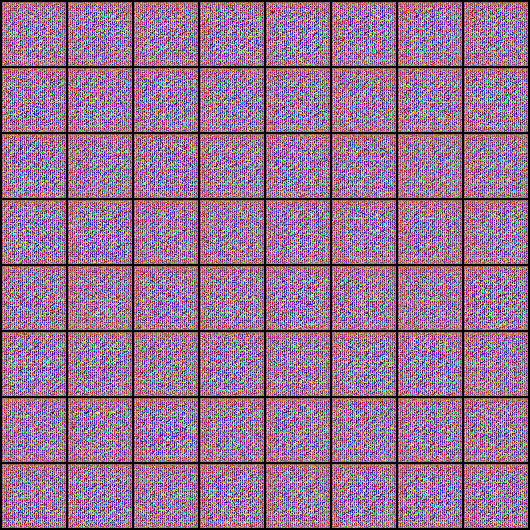

In [ ]:
Image('/content/generated-images/generated-images-0000.png')

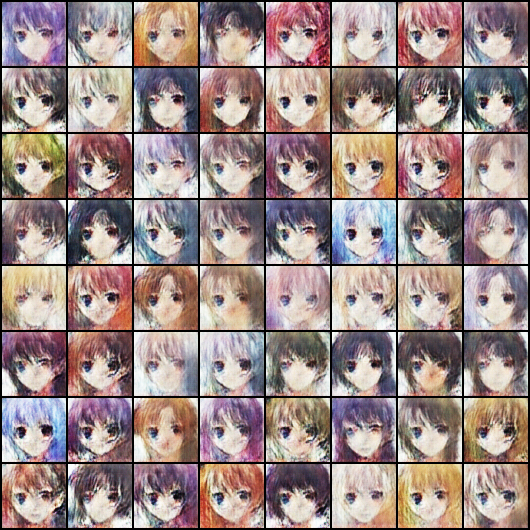

In [ ]:
Image('/content/generated-images/generated-images-0005.png')

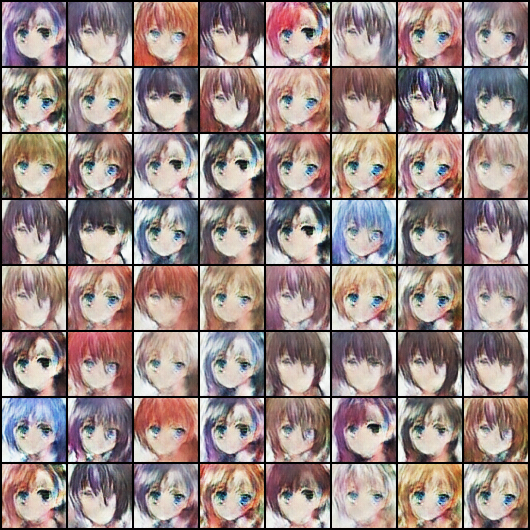

In [ ]:
Image('/content/generated-images/generated-images-0010.png')

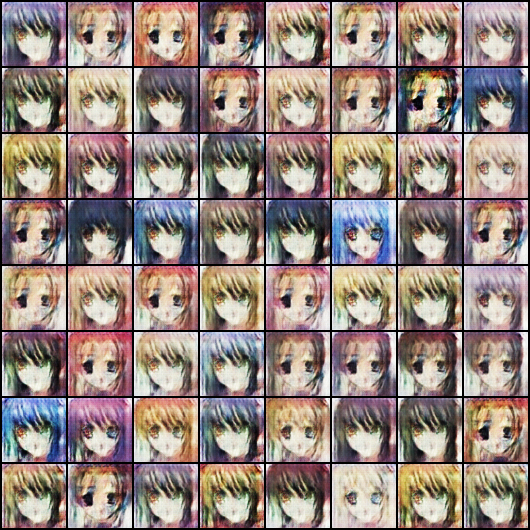

In [ ]:
Image('/content/generated-images/generated-images-0015.png')